# PKO-T5를 이용한 문장 순서 예측

이 노트북에서는 paust/pko-t5-large 모델을 사용하여 문장 순서 예측을 구현합니다. 다음과 같은 과정을 수행합니다:

1. 데이터 로드 및 전처리
2. 모델 및 학습 설정
3. Early stopping과 체크포인팅을 적용한 학습
4. 모델 평가
5. 하이퍼파라미터 튜닝

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch.optim import AdamW
from transformers import get_linear_schedule_with_warmup
from tqdm.notebook import tqdm
import os
import json
import gc

from t5_utils import SentenceOrderPredictor, compute_accuracy

# 한글 폰트 설정
plt.rc('font', family='Malgun Gothic')

# 결과 저장을 위한 디렉토리 생성
os.makedirs('checkpoints', exist_ok=True)
os.makedirs('history', exist_ok=True)
os.makedirs('grid_search_results', exist_ok=True)

## 1. 데이터 로드 및 준비

In [2]:
# 전처리된 데이터 로드
df = pd.read_csv('../data/cleaned_seq2seq.csv')

# 데이터 확인
print("데이터셋 크기:", len(df))
print("\n샘플 데이터:")
df.head(5)

데이터셋 크기: 7351

샘플 데이터:


,input_text,target_text
0,블록체인 기술은 투표 과정의 투명성을 크게 향상시킬 수 있다. [SEP] 이러한 특...,0 3 1 2
1,줄거리 자동 생성의 인공지능 알고리즘은 대량의 텍스트 데이터를 분석하여 핵심 정보를...,0 3 2 1
2,"마지막으로, 키친타올을 보관할 때는 쉽게 접근할 수 있는 곳에 두어 낭비를 방지하는...",3 2 1 0
3,책의 페이지가 손상되지 않도록 수직으로 세워 두거나 평평하게 눕혀 보관하는 것이 좋...,2 0 1 3
4,"인공지능 모델은 반복적인 실험을 통해 지속적으로 학습하며, 이를 통해 발견의 정확성...",1 3 0 2


In [3]:
# # 데이터셋 랜덤 샘플링 (20,000개)
# sample_df = df.sample(n=20000, random_state=43)

# # 데이터 확인
# print("데이터셋 크기:", len(sample_df))
# print("\n샘플 데이터:")
# sample_df.head(5)

In [4]:
# pko-t5-large 모델 초기화
predictor = SentenceOrderPredictor()

# 데이터셋 준비 (9:1 비율로 분할)
train_dataset, val_dataset = predictor.prepare_data(df)

# 데이터로더 생성
batch_size = 4
train_loader, val_loader = predictor.create_dataloaders(train_dataset, val_dataset, batch_size=batch_size)

print(f"학습 데이터 크기: {len(train_dataset)}")
print(f"검증 데이터 크기: {len(val_dataset)}")

Using device: cuda
Model device: cuda:0
학습 데이터 크기: 6615
검증 데이터 크기: 736


## 2. 학습 설정

In [5]:
# 학습 파라미터
num_epochs = 10
learning_rate = 2e-5
warmup_steps = 1000  # Warmup 스텝 수
gradient_accumulation_steps = 4  # Gradient accumulation 스텝 수
patience = 3  # Early stopping 인내심
min_delta = 1e-4  # 최소 개선 기준

# 옵티마이저 설정
optimizer = AdamW(predictor.model.parameters(), lr=learning_rate)

# Learning rate scheduler 설정
num_training_steps = len(train_loader) * num_epochs
scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=warmup_steps,
    num_training_steps=num_training_steps
)

# Mixed precision training을 위한 scaler 설정
scaler = torch.amp.GradScaler('cuda')

# 학습 히스토리 초기화
history = {
    'train_loss': [],
    'val_loss': [],
    'val_accuracy': [],
    'learning_rates': []  # learning rate 기록 추가
}

## 3. Early Stopping을 적용한 학습

In [6]:
def validate(model, val_loader, device, tokenizer):
    """검증 데이터에 대한 모델 평가"""
    model.eval()
    total_loss = 0
    total_correct = 0
    total_samples = 0
    
    with torch.no_grad():
        for batch in tqdm(val_loader, desc='Validation'):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)
            
            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask,
                labels=labels
            )
            
            loss = outputs.loss
            total_loss += loss.item()
            
            # 예측 생성
            predictions = model.generate(
                input_ids=input_ids,
                attention_mask=attention_mask,
                max_length=8,
                num_beams=4,
                no_repeat_ngram_size=4  # 숫자 중복 방지
            )
            
            # 예측과 레이블을 순서 시퀀스로 변환
            pred_texts = [tokenizer.decode(pred, skip_special_tokens=True) for pred in predictions]
            label_texts = [tokenizer.decode(label, skip_special_tokens=True) for label in labels]
            
            try:
                # 예측과 레이블을 정수 리스트로 변환
                pred_orders = [list(map(int, text.split())) for text in pred_texts]
                label_orders = [list(map(int, text.split())) for text in label_texts]
                
                # 정확도 계산
                correct = sum(compute_accuracy(pred, label) for pred, label in zip(pred_orders, label_orders))
                total_correct += correct
                total_samples += len(input_ids)
            except ValueError as e:
                print(f"Warning: 잘못된 예측 형식 발견 - {e}")
                print(f"Predictions: {pred_texts}")
                print(f"Labels: {label_texts}")
                continue
    
    avg_loss = total_loss / len(val_loader)  # 배치 수로 나누기
    accuracy = total_correct / total_samples if total_samples > 0 else 0
    
    return avg_loss, accuracy

In [ ]:
# 학습 시작 전에 실행
# CUDA 캐시 초기화
torch.cuda.empty_cache()

# 가비지 컬렉션 강제 실행
gc.collect()

# CUDA 초기화
if torch.cuda.is_available():
    torch.cuda.init()
    torch.cuda.synchronize()

In [13]:
# 학습 루프
best_val_loss = float('inf')
best_val_accuracy = 0
best_epoch = -1
patience_counter = 0

for epoch in range(num_epochs):
    # 학습 단계
    predictor.model.train()
    total_train_loss = 0
    optimizer.zero_grad()  # 에폭 시작 시 gradient 초기화
    
    for batch_idx, batch in enumerate(tqdm(train_loader, desc=f'Epoch {epoch+1}/{num_epochs} - Training')):
        input_ids = batch['input_ids'].to(predictor.device)
        attention_mask = batch['attention_mask'].to(predictor.device)
        labels = batch['labels'].to(predictor.device)
        
        # Mixed precision training
        with torch.amp.autocast('cuda'):
            outputs = predictor.model(
                input_ids=input_ids,
                attention_mask=attention_mask,
                labels=labels
            )
            loss = outputs.loss / gradient_accumulation_steps  # loss를 gradient accumulation 스텝으로 나눔
        
        # Scaled backward pass
        scaler.scale(loss).backward()
        
        if (batch_idx + 1) % gradient_accumulation_steps == 0:
            # Gradient clipping
            scaler.unscale_(optimizer)
            torch.nn.utils.clip_grad_norm_(predictor.model.parameters(), max_norm=1.0)
            
            # Optimizer step with scaler
            scaler.step(optimizer)
            scaler.update()
            optimizer.zero_grad()
            
            # Learning rate scheduler step
            scheduler.step()
        
        total_train_loss += loss.item() * gradient_accumulation_steps
    
    avg_train_loss = total_train_loss / len(train_loader)
    
    # 검증
    val_loss, val_accuracy = validate(predictor.model, val_loader, predictor.device, predictor.tokenizer)
    
    # 히스토리 업데이트
    history['train_loss'].append(avg_train_loss)
    history['val_loss'].append(val_loss)
    history['val_accuracy'].append(val_accuracy)
    history['learning_rates'].append(scheduler.get_last_lr()[0])  # 현재 learning rate 기록
    
    # 현재 성능 출력
    print(f'Epoch {epoch+1}/{num_epochs}')
    print(f'Train Loss: {avg_train_loss:.4f}')
    print(f'Validation Loss: {val_loss:.4f}')
    print(f'Validation Accuracy: {val_accuracy:.4f}')
    print(f'Learning Rate: {scheduler.get_last_lr()[0]:.2e}')
    
    # Early stopping 및 체크포인트 저장 로직
    if val_loss < best_val_loss - min_delta:  # 유의미한 개선이 있는 경우
        print(f'Validation loss improved from {best_val_loss:.4f} to {val_loss:.4f}')
        best_val_loss = val_loss
        best_val_accuracy = val_accuracy
        best_epoch = epoch
        patience_counter = 0
        
        # 체크포인트 저장
        predictor.save_checkpoint(
            epoch=epoch,
            model=predictor.model,
            optimizer=optimizer,
            loss=val_loss,
            path=f'checkpoints/pko_t5_best_model.pt'
        )
    else:
        patience_counter += 1
        print(f'No improvement for {patience_counter} epochs (best val_loss: {best_val_loss:.4f} at epoch {best_epoch+1})')
        
    if patience_counter >= patience:
        print(f'Early stopping at epoch {epoch+1}')
        break

# 학습 완료 후 최종 결과 출력
print('\n학습 완료!')
print(f'Best epoch: {best_epoch+1}')
print(f'Best validation loss: {best_val_loss:.4f}')
print(f'Best validation accuracy: {best_val_accuracy:.4f}')

# 최종 학습 히스토리 저장
predictor.save_history(history, 'history/pko_t5_history.json')

Epoch 1/10 - Training:   0%|          | 0/1654 [00:00<?, ?it/s]

Validation:   0%|          | 0/184 [00:00<?, ?it/s]

Epoch 1/10
Train Loss: 0.1145
Validation Loss: 0.1018
Validation Accuracy: 0.6739
Learning Rate: 1.92e-05
Validation loss improved from inf to 0.1018


Epoch 2/10 - Training:   0%|          | 0/1654 [00:00<?, ?it/s]

Validation:   0%|          | 0/184 [00:00<?, ?it/s]

Epoch 2/10
Train Loss: 0.0875
Validation Loss: 0.0941
Validation Accuracy: 0.7391
Learning Rate: 1.86e-05
Validation loss improved from 0.1018 to 0.0941


Epoch 3/10 - Training:   0%|          | 0/1654 [00:00<?, ?it/s]

Validation:   0%|          | 0/184 [00:00<?, ?it/s]

Epoch 3/10
Train Loss: 0.0666
Validation Loss: 0.0960
Validation Accuracy: 0.7405
Learning Rate: 1.81e-05
No improvement for 1 epochs (best val_loss: 0.0941 at epoch 2)


Epoch 4/10 - Training:   0%|          | 0/1654 [00:00<?, ?it/s]

Validation:   0%|          | 0/184 [00:00<?, ?it/s]

Epoch 4/10
Train Loss: 0.0508
Validation Loss: 0.1085
Validation Accuracy: 0.7622
Learning Rate: 1.76e-05
No improvement for 2 epochs (best val_loss: 0.0941 at epoch 2)


Epoch 5/10 - Training:   0%|          | 0/1654 [00:00<?, ?it/s]

Validation:   0%|          | 0/184 [00:00<?, ?it/s]

Epoch 5/10
Train Loss: 0.0391
Validation Loss: 0.1132
Validation Accuracy: 0.7772
Learning Rate: 1.70e-05
No improvement for 3 epochs (best val_loss: 0.0941 at epoch 2)
Early stopping at epoch 5

학습 완료!
Best epoch: 2
Best validation loss: 0.0941
Best validation accuracy: 0.7391


In [9]:
predictor.save_history(history, 'history/pko_t5_history.json')

In [ ]:
# 학습 재개를 위한 체크포인트 로드
try:
    # 가장 최근 체크포인트 파일 찾기
    checkpoint_files = [f for f in os.listdir('checkpoints') if f.startswith('pko_t5_best_model')]
    if checkpoint_files:
        latest_checkpoint = max(checkpoint_files, key=lambda x: os.path.getctime(os.path.join('checkpoints', x)))
        checkpoint_path = os.path.join('checkpoints', latest_checkpoint)
        
        print(f"Attempting to load checkpoint from: {checkpoint_path}")
        
        # 체크포인트 로드 - strict=True로 설정
        checkpoint = torch.load(
            checkpoint_path,
            map_location=predictor.device,
            _use_new_zipfile_serialization=False
        )
        
        # 모델 상태 로드 - strict=True로 설정
        predictor.model.load_state_dict(checkpoint['model_state_dict'], strict=True)
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        
        # 히스토리 로드
        history_path = 'history/pko_t5_history.json'
        if os.path.exists(history_path):
            with open(history_path, 'r') as f:
                history = json.load(f)
        else:
            history = {
                'train_loss': [],
                'val_loss': [],
                'val_accuracy': [],
                'learning_rates': []
            }
        
        start_epoch = checkpoint['epoch'] + 1
        best_val_loss = checkpoint['loss']
        best_val_accuracy = max(history['val_accuracy'])
        best_epoch = checkpoint['epoch']
        patience_counter = 0
        
        print(f"Successfully loaded checkpoint: {latest_checkpoint}")
        print(f"Last epoch: {checkpoint['epoch']}")
        print(f"Best validation loss: {checkpoint['loss']:.4f}")
    else:
        print("No checkpoint found. Starting from scratch.")
        start_epoch = 0
        best_val_loss = float('inf')
        best_val_accuracy = 0
        best_epoch = -1
        patience_counter = 0
        history = {
            'train_loss': [],
            'val_loss': [],
            'val_accuracy': [],
            'learning_rates': []
        }
except Exception as e:
    print(f"Error loading checkpoint: {e}")
    start_epoch = 0
    best_val_loss = float('inf')
    best_val_accuracy = 0
    best_epoch = -1
    patience_counter = 0
    history = {
        'train_loss': [],
        'val_loss': [],
        'val_accuracy': [],
        'learning_rates': []
    }

# 학습 루프
for epoch in range(start_epoch, num_epochs):
    # 학습 단계
    predictor.model.train()
    total_train_loss = 0
    optimizer.zero_grad()  # 에폭 시작 시 gradient 초기화
    
    for batch_idx, batch in enumerate(tqdm(train_loader, desc=f'Epoch {epoch+1}/{num_epochs} - Training')):
        input_ids = batch['input_ids'].to(predictor.device)
        attention_mask = batch['attention_mask'].to(predictor.device)
        labels = batch['labels'].to(predictor.device)
        
        # Mixed precision training
        with torch.amp.autocast('cuda'):
            outputs = predictor.model(
                input_ids=input_ids,
                attention_mask=attention_mask,
                labels=labels
            )
            loss = outputs.loss / gradient_accumulation_steps  # loss를 gradient accumulation 스텝으로 나눔
        
        # Scaled backward pass
        scaler.scale(loss).backward()
        
        if (batch_idx + 1) % gradient_accumulation_steps == 0:
            # Gradient clipping
            scaler.unscale_(optimizer)
            torch.nn.utils.clip_grad_norm_(predictor.model.parameters(), max_norm=1.0)
            
            # Optimizer step with scaler
            scaler.step(optimizer)
            scaler.update()
            optimizer.zero_grad()
            
            # Learning rate scheduler step
            scheduler.step()
        
        total_train_loss += loss.item() * gradient_accumulation_steps
    
    avg_train_loss = total_train_loss / len(train_loader)
    
    # 검증
    val_loss, val_accuracy = validate(predictor.model, val_loader, predictor.device, predictor.tokenizer)
    
    # 히스토리 업데이트
    history['train_loss'].append(avg_train_loss)
    history['val_loss'].append(val_loss)
    history['val_accuracy'].append(val_accuracy)
    history['learning_rates'].append(scheduler.get_last_lr()[0])  # 현재 learning rate 기록
    
    # 현재 성능 출력
    print(f'Epoch {epoch+1}/{num_epochs}')
    print(f'Train Loss: {avg_train_loss:.4f}')
    print(f'Validation Loss: {val_loss:.4f}')
    print(f'Validation Accuracy: {val_accuracy:.4f}')
    print(f'Learning Rate: {scheduler.get_last_lr()[0]:.2e}')
    
    # Early stopping 및 체크포인트 저장 로직
    if val_loss < best_val_loss - min_delta:  # 유의미한 개선이 있는 경우
        print(f'Validation loss improved from {best_val_loss:.4f} to {val_loss:.4f}')
        best_val_loss = val_loss
        best_val_accuracy = val_accuracy
        best_epoch = epoch
        patience_counter = 0
        
        # 체크포인트 저장
        predictor.save_checkpoint(
            epoch=epoch,
            model=predictor.model,
            optimizer=optimizer,
            loss=val_loss,
            path=f'checkpoints/pko_t5_best_model.pt'
        )
    else:
        patience_counter += 1
        print(f'No improvement for {patience_counter} epochs (best val_loss: {best_val_loss:.4f} at epoch {best_epoch+1})')
        
    if patience_counter >= patience:
        print(f'Early stopping at epoch {epoch+1}')
        break

# 학습 완료 후 최종 결과 출력
print('\n학습 완료!')
print(f'Best epoch: {best_epoch+1}')
print(f'Best validation loss: {best_val_loss:.4f}')
print(f'Best validation accuracy: {best_val_accuracy:.4f}')

# 최종 학습 히스토리 저장
predictor.save_history(history, 'history/pko_t5_history.json')

## 4. 학습 결과 시각화

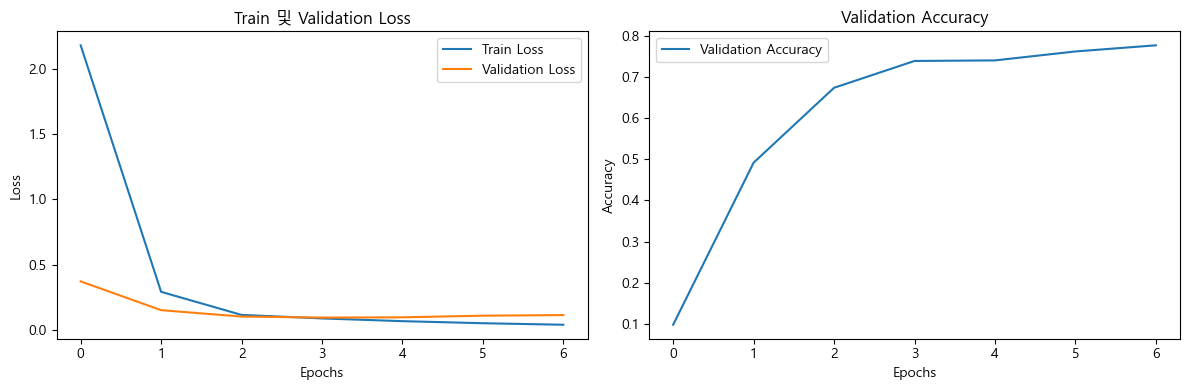

In [14]:
plt.figure(figsize=(12, 4))

# Loss 그래프
plt.subplot(1, 2, 1)
plt.plot(history['train_loss'], label='Train Loss')
plt.plot(history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Train 및 Validation Loss')
plt.legend()

# Accuracy 그래프
plt.subplot(1, 2, 2)
plt.plot(history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Validation Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

## 5. 모델 검정

In [8]:
# 모델 체크포인트 경로 설정
CHECKPOINT_PATH = 'checkpoints/pko_t5_best_model.pt'

In [9]:
# 최적 모델 불러오기
predictor.load_checkpoint(CHECKPOINT_PATH)

# 테스트할 텍스트
test_text = df['input_text'].iloc[0]  # 첫 번째 샘플로 테스트
true_order = df['target_text'].iloc[0]

# 예측
predicted_order = predictor.predict_order(test_text)

print("입력 텍스트:")
print(test_text)
print("\n예측된 순서:", predicted_order)
print("실제 순서:", true_order)
print("정확도:", compute_accuracy(predicted_order, true_order))

입력 텍스트:
블록체인 기술은 투표 과정의 투명성을 크게 향상시킬 수 있다. [SEP] 이러한 특성은 유권자들에게 신뢰를 제공하며, 민주적 참여를 촉진하는 데 기여할 수 있다. [SEP] 결과적으로 블록체인 기반의 투표 시스템은 공정하고 신뢰할 수 있는 선거 환경을 조성할 잠재력을 지닌다. [SEP] 각 투표는 변경 불가능한 기록으로 저장되어 조작의 가능성을 원천적으로 차단한다.

예측된 순서: [0, 3, 1, 2]
실제 순서: 0 3 1 2
정확도: 1


In [10]:
from sklearn.metrics import precision_score, recall_score, f1_score

def evaluate_all_metrics(predictor, df):
    """
    전체 데이터셋에 대한 평가 메트릭을 계산
    
    Args:
        predictor: 학습된 모델
        df: 평가할 데이터프레임
    
    Returns:
        dict: 각종 평가 메트릭
    """
    all_accuracies = []
    all_true_orders = []
    all_pred_orders = []
    
    print("전체 데이터셋 평가 중...")
    for idx in tqdm(range(len(df))):
        test_text = df['input_text'].iloc[idx]
        true_order = df['target_text'].iloc[idx]
        
        try:
            # 예측
            predicted_order = predictor.predict_order(test_text)
            
            # true_order가 문자열이면 리스트로 변환
            if isinstance(true_order, str):
                true_order = list(map(int, true_order.split()))
            
            # predicted_order가 문자열이면 리스트로 변환
            if isinstance(predicted_order, str):
                predicted_order = list(map(int, predicted_order.split()))
            
            # 정확도 계산
            accuracy = compute_accuracy(predicted_order, true_order)
            all_accuracies.append(accuracy)
            
            # 순서 저장
            all_true_orders.extend(true_order)
            all_pred_orders.extend(predicted_order)
            
        except Exception as e:
            print(f"Warning: 샘플 {idx}에서 오류 발생 - {str(e)}")
            print(f"Input text: {test_text}")
            print(f"True order: {true_order}")
            print(f"Predicted order: {predicted_order}")
            continue
    
    if not all_accuracies:
        print("Warning: 평가할 수 있는 샘플이 없습니다.")
        return None
    
    # 전체 메트릭 계산
    metrics = {
        'accuracy': np.mean(all_accuracies),
        'precision': precision_score(all_true_orders, all_pred_orders, average='macro'),
        'recall': recall_score(all_true_orders, all_pred_orders, average='macro'),
        'f1': f1_score(all_true_orders, all_pred_orders, average='macro')
    }
    
    return metrics

In [11]:
# 모델 로드
predictor.load_checkpoint('checkpoints/pko_t5_best_model.pt')

# 전체 데이터셋 평가
metrics = evaluate_all_metrics(predictor, df)

print("\n=== 전체 데이터셋 평가 결과 ===")
print(f"전체 정확도: {metrics['accuracy']:.4f}")
print(f"Precision: {metrics['precision']:.4f}")
print(f"Recall: {metrics['recall']:.4f}")
print(f"F1-Score: {metrics['f1']:.4f}")

전체 데이터셋 평가 중...


  0%|          | 0/7351 [00:00<?, ?it/s]


=== 전체 데이터셋 평가 결과 ===
전체 정확도: 0.8821
Precision: 0.9398
Recall: 0.9398
F1-Score: 0.9398


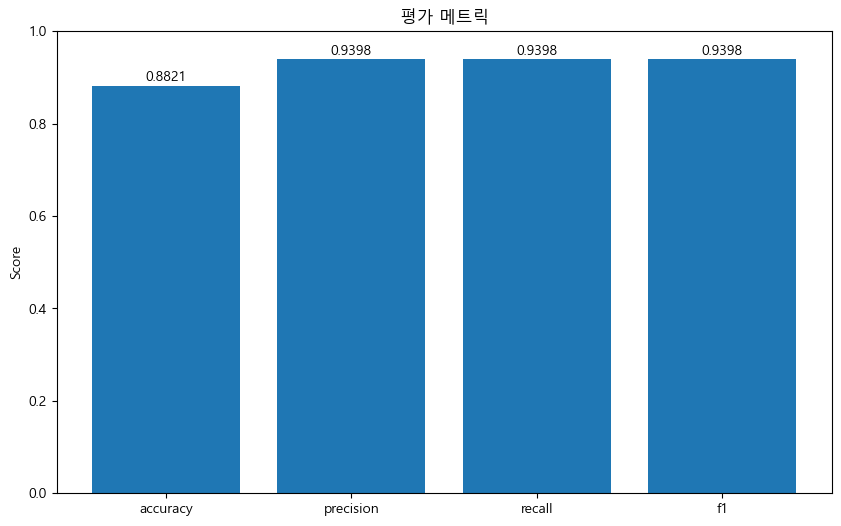

In [12]:
# 결과를 시각화
plt.figure(figsize=(10, 6))
metrics_values = list(metrics.values())
metrics_names = list(metrics.keys())

plt.bar(metrics_names, metrics_values)
plt.title('평가 메트릭')
plt.ylabel('Score')
plt.ylim(0, 1)

for i, v in enumerate(metrics_values):
    plt.text(i, v + 0.01, f'{v:.4f}', ha='center')

plt.show()

## 6. 하이퍼파라미터 튜닝

In [6]:
def train_with_params(learning_rate, batch_size, max_epochs, train_dataset, val_dataset, model_name="paust/pko-t5-base", use_auto_classes=False):
    """주어진 하이퍼파라미터로 모델 학습"""
    try:
        # GPU 사용 가능 여부 확인
        print(f"CUDA 사용 가능: {torch.cuda.is_available()}")
        if torch.cuda.is_available():
            print(f"현재 사용 중인 GPU: {torch.cuda.get_device_name()}")
    
        # 모델과 옵티마이저 초기화
        predictor = SentenceOrderPredictor(model_name=model_name, use_auto_classes=use_auto_classes)
        optimizer = AdamW(predictor.model.parameters(), lr=learning_rate)
        print(f"모델이 있는 디바이스: {next(predictor.model.parameters()).device}")
        
        # 데이터로더 생성
        train_loader, val_loader = predictor.create_dataloaders(train_dataset, val_dataset, batch_size=batch_size)
        first_batch = next(iter(train_loader))
        print(f"입력 데이터 디바이스: {first_batch['input_ids'].device}")

        best_val_loss = float('inf')
        best_val_accuracy = 0
        best_epoch = -1
        patience_counter = 0
        patience = 3
        min_delta = 1e-4
        
        for epoch in range(max_epochs):
            # 학습
            predictor.model.train()
            total_train_loss = 0

            for batch in tqdm(train_loader, desc=f'Epoch {epoch+1}/{max_epochs} - Training'):
                optimizer.zero_grad()
                
                # 배치 데이터를 GPU로 이동
                input_ids = batch['input_ids'].to(predictor.device)
                attention_mask = batch['attention_mask'].to(predictor.device)
                labels = batch['labels'].to(predictor.device)
                
                outputs = predictor.model(
                    input_ids=input_ids,
                    attention_mask=attention_mask,
                    labels=labels
                )
                
                loss = outputs.loss
                loss.backward()
                optimizer.step()
                
                total_train_loss += loss.item()
            
            avg_train_loss = total_train_loss / len(train_loader)
            
            # Validation
            val_loss, val_accuracy = validate(predictor.model, val_loader, predictor.device, predictor.tokenizer)
            
            print(f'Epoch {epoch+1}/{max_epochs}')
            print(f'Train Loss: {avg_train_loss:.4f}')
            print(f'Validation Loss: {val_loss:.4f}')
            print(f'Validation Accuracy: {val_accuracy:.4f}')
            
            if val_loss < best_val_loss - min_delta:
                print(f'Validation loss improved from {best_val_loss:.4f} to {val_loss:.4f}')
                best_val_loss = val_loss
                best_val_accuracy = val_accuracy
                best_epoch = epoch
                patience_counter = 0
            else:
                patience_counter += 1
                print(f'No improvement for {patience_counter} epochs (best val_loss: {best_val_loss:.4f} at epoch {best_epoch+1})')
                
            if patience_counter >= patience:
                print(f'Early stopping at epoch {epoch+1}')
                break
        
        return best_val_loss, best_val_accuracy
    
    finally:
        # 메모리 정리
        del predictor
        del optimizer
        torch.cuda.empty_cache()

In [7]:
def run_grid_search(train_dataset, val_dataset, model_name="paust/pko-t5-base", use_auto_classes=False):
    """그리드 서치 수행"""
    # 그리드 서치 파라미터
    param_grid = {
        'learning_rate': [1e-5, 2e-5, 5e-5],
        'batch_size': [4, 8, 16],
        'max_epochs': [5, 10]
    }

    # 결과 저장용 리스트
    results = []
    best_params = None
    best_accuracy = 0

    # 총 시도 횟수 계산
    total_trials = len(param_grid['learning_rate']) * len(param_grid['batch_size']) * len(param_grid['max_epochs'])
    trial_count = 0

    for lr in param_grid['learning_rate']:
        for bs in param_grid['batch_size']:
            for epochs in param_grid['max_epochs']:
                trial_count += 1
                print(f'\n[Trial {trial_count}/{total_trials}]')
                print(f'Parameters: Learning Rate={lr}, Batch Size={bs}, Max Epochs={epochs}')
                
                val_loss, val_acc = train_with_params(
                    learning_rate=lr,
                    batch_size=bs,
                    max_epochs=epochs,
                    train_dataset=train_dataset,
                    val_dataset=val_dataset,
                    model_name=model_name,
                    use_auto_classes=use_auto_classes
                )
                
                results.append({
                    'learning_rate': lr,
                    'batch_size': bs,
                    'max_epochs': epochs,
                    'val_loss': val_loss,
                    'val_accuracy': val_acc
                })
                
                # 최고 성능 업데이트
                if val_acc > best_accuracy:
                    best_accuracy = val_acc
                    best_params = {
                        'learning_rate': lr,
                        'batch_size': bs,
                        'max_epochs': epochs
                    }
                
                print(f'Results: Val Loss={val_loss:.4f}, Val Accuracy={val_acc:.4f}')

    # 결과를 DataFrame으로 변환
    results_df = pd.DataFrame(results)
    results_df = results_df.sort_values('val_accuracy', ascending=False)
    
    # 결과 저장
    results_df.to_csv(f'grid_search_results/pko_t5_results.csv', index=False)
    
    print('\n=== 그리드 서치 완료 ===')
    print('\n최적의 하이퍼파라미터:')
    print(f'Learning Rate: {best_params["learning_rate"]}')
    print(f'Batch Size: {best_params["batch_size"]}')
    print(f'Max Epochs: {best_params["max_epochs"]}')
    print(f'Best Validation Accuracy: {best_accuracy:.4f}')
    
    return results_df, best_params

In [ ]:
# 학습 시작 전에 실행
import gc

# CUDA 캐시 초기화
torch.cuda.empty_cache()

# 가비지 컬렉션 강제 실행
gc.collect()

# CUDA 초기화
if torch.cuda.is_available():
    torch.cuda.init()
    torch.cuda.synchronize()
    
# 그리드 서치 실행
results_df, best_params = run_grid_search(
    train_dataset=train_dataset,
    val_dataset=val_dataset,
    model_name="paust/pko-t5-base",
    use_auto_classes=False
)

# 상위 5개 결과 표시
results_df.head()

In [10]:
# 상위 5개 결과 표시
results_df.head(10)

,learning_rate,batch_size,max_epochs,val_loss,val_accuracy
12,0.00005,4,5,0.084035,0.766304
7,0.00002,4,10,0.090930,0.741848
15,0.00005,8,10,0.097464,0.741848
13,0.00005,4,10,0.087579,0.737772
9,0.00002,8,10,0.087891,0.732337
17,0.00005,16,10,0.090687,0.730978
1,0.00001,4,10,0.094635,0.721467
11,0.00002,16,10,0.093995,0.714674
14,0.00005,8,5,0.101586,0.698370
16,0.00005,16,5,0.096903,0.682065


## 7. 최적 모델로 예측 테스트

In [5]:
# 모델 체크포인트 경로 설정
CHECKPOINT_PATH = 'checkpoints/pko_t5_best_model.pt'

In [ ]:
# 최적 모델 불러오기
predictor.load_checkpoint(CHECKPOINT_PATH)

# 테스트할 텍스트
test_text = df['input_text'].iloc[0]  # 첫 번째 샘플로 테스트
true_order = df['target_text'].iloc[0]

# 예측
predicted_order = predictor.predict_order(test_text)

print("입력 텍스트:")
print(test_text)
print("\n예측된 순서:", predicted_order)
print("실제 순서:", true_order)
print("정확도:", compute_accuracy(predicted_order, true_order))

In [13]:
from sklearn.metrics import precision_score, recall_score, f1_score

def evaluate_all_metrics(predictor, df):
    """
    전체 데이터셋에 대한 평가 메트릭을 계산
    
    Args:
        predictor: 학습된 모델
        df: 평가할 데이터프레임
    
    Returns:
        dict: 각종 평가 메트릭
    """
    all_accuracies = []
    all_true_orders = []
    all_pred_orders = []
    
    print("전체 데이터셋 평가 중...")
    for idx in tqdm(range(len(df))):
        test_text = df['input_text'].iloc[idx]
        true_order = df['target_text'].iloc[idx]
        
        try:
            # 예측
            predicted_order = predictor.predict_order(test_text)
            
            # true_order가 문자열이면 리스트로 변환
            if isinstance(true_order, str):
                true_order = list(map(int, true_order.split()))
            
            # predicted_order가 문자열이면 리스트로 변환
            if isinstance(predicted_order, str):
                predicted_order = list(map(int, predicted_order.split()))
            
            # 정확도 계산
            accuracy = compute_accuracy(predicted_order, true_order)
            all_accuracies.append(accuracy)
            
            # 순서 저장
            all_true_orders.extend(true_order)
            all_pred_orders.extend(predicted_order)
            
        except Exception as e:
            print(f"Warning: 샘플 {idx}에서 오류 발생 - {str(e)}")
            print(f"Input text: {test_text}")
            print(f"True order: {true_order}")
            print(f"Predicted order: {predicted_order}")
            continue
    
    if not all_accuracies:
        print("Warning: 평가할 수 있는 샘플이 없습니다.")
        return None
    
    # 전체 메트릭 계산
    metrics = {
        'accuracy': np.mean(all_accuracies),
        'precision': precision_score(all_true_orders, all_pred_orders, average='macro'),
        'recall': recall_score(all_true_orders, all_pred_orders, average='macro'),
        'f1': f1_score(all_true_orders, all_pred_orders, average='macro')
    }
    
    return metrics

In [ ]:
# 모델 로드
predictor.load_checkpoint('checkpoints/pko_t5_best_model.pt')

# 전체 데이터셋 평가
metrics = evaluate_all_metrics(predictor, df)

print("\n=== 전체 데이터셋 평가 결과 ===")
print(f"전체 정확도: {metrics['accuracy']:.4f}")
print(f"Precision: {metrics['precision']:.4f}")
print(f"Recall: {metrics['recall']:.4f}")
print(f"F1-Score: {metrics['f1']:.4f}")

In [ ]:
# 결과를 시각화
plt.figure(figsize=(10, 6))
metrics_values = list(metrics.values())
metrics_names = list(metrics.keys())

plt.bar(metrics_names, metrics_values)
plt.title('평가 메트릭')
plt.ylabel('Score')
plt.ylim(0, 1)

for i, v in enumerate(metrics_values):
    plt.text(i, v + 0.01, f'{v:.4f}', ha='center')

plt.show()

## 8. 테스트 데이터 예측

In [4]:
# 테스트 데이터 로드
test_df = pd.read_csv('../data/test.csv')

# 모델 로드
predictor = SentenceOrderPredictor()

# 체크포인트 로드 시 메모리 효율적인 방식 사용
checkpoint = torch.load('./checkpoints/pko_t5_best_model.pt', map_location='cpu')
predictor.model.load_state_dict(checkpoint['model_state_dict'])
predictor.model.to('cuda')

# 불필요한 메모리 해제
del checkpoint
torch.cuda.empty_cache()

# 예측 결과를 저장할 리스트
predictions = []

# 각 테스트 케이스에 대해 예측 수행
for idx, row in tqdm(test_df.iterrows(), total=len(test_df), desc="Predicting"):
    # 입력 텍스트 준비 ([SEP]로 문장들 연결)
    input_text = f"{row['sentence_0']} [SEP] {row['sentence_1']} [SEP] {row['sentence_2']} [SEP] {row['sentence_3']}"
    
    # 순서 예측
    predicted_order = predictor.predict_order(input_text)
    
    # 예측 결과를 문자열로 변환 (공백으로 구분)
    prediction_str = ' '.join(map(str, predicted_order))
    predictions.append(prediction_str)

Using device: cuda
Model device: cuda:0


Predicting:   0%|          | 0/1780 [00:00<?, ?it/s]

In [5]:
test_df.head(2)

,ID,sentence_0,sentence_1,sentence_2,sentence_3
0,TEST_0000,"자유 의지와 결정론은 서로 상충하는 개념으로 여겨지지만, 이 둘의 공존 가능성도 탐...","결정론은 모든 사건이 원인과 결과의 연쇄에 의해 발생한다고 주장하며, 이는 인간의 ...",그러나 인간의 인식과 선택 과정에서 나타나는 복잡성과 예측 불가능성은 자유 의지의 ...,"결국, 자유 의지와 결정론은 서로를 배제하기보다는, 인간 경험의 다양한 측면을 설명..."
1,TEST_0001,사회적 낙인은 개인의 자아 존중감에 부정적인 영향을 미친다.,"건강 불평등은 이러한 낙인으로 인해 더욱 심화되며, 특정 집단이 의료 서비스 접근에...","결국, 사회적 낙인과 건강 불평등은 서로 연결되어 있으며, 이를 해결하기 위한 포괄...","낙인으로 인해 사람들은 사회적 고립을 경험하고, 이는 정신적 및 신체적 건강에 악영..."


In [6]:
predictions[:2]

['0 1 2 3', '0 3 1 2']

In [7]:
# 예측 결과를 제출 형식에 맞게 변환
submission = pd.DataFrame({
    'ID': test_df['ID'],
    'answer_0': [pred[0] for pred in predictions],
    'answer_1': [pred[2] for pred in predictions],
    'answer_2': [pred[4] for pred in predictions],
    'answer_3': [pred[6] for pred in predictions]
})

# 결과를 CSV 파일로 저장
submission.to_csv('../data/submission.csv', index=False)

In [8]:
submission

,ID,answer_0,answer_1,answer_2,answer_3
0,TEST_0000,0,1,2,3
1,TEST_0001,0,3,1,2
2,TEST_0002,0,3,2,1
3,TEST_0003,3,2,1,0
4,TEST_0004,0,2,1,3
...,...,...,...,...,...
1775,TEST_1775,3,1,0,2
1776,TEST_1776,1,3,2,0
1777,TEST_1777,2,1,3,0
1778,TEST_1778,2,1,0,3
